In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import pandas as pd
%matplotlib inline
import pyram as pr
from sklearn.linear_model import LinearRegression
import scipy
from itertools import combinations
from itertools import product

Welcome to pyram: your Raman analysis library!


In [2]:
pr.charge_lib('full')
#pr.charge_lib('short')

Charging pure spectra library, needs around a minute ....
Done. Good work!


In [3]:
pr.cwd('example_data')
pr.set_alias()

txt0  ->  Sample01_A_10x6s_633nm_G1200_F100__Ox100LWD.txt
txt1  ->  Sample01_B_10x30s_633nm_G1200_F1__Ox100LWD.txt
txt2  ->  Sample01_C_10x20s_633nm_G1200_F10__Ox100LWD.txt
txt3  ->  Sample01_D_6x4s_633nm_G1200_F100__Ox10.txt
txt4  ->  Sample01_E_6x4s_633nm_G1200_F100__Ox100LWD.txt
txt5  ->  Sample01_F_10x5s_633nm_G1200_F0_1__Ox100LWD.txt
txt6  ->  Sample01_G_6x10s_633nm_G1200_F10__Ox100LWD.txt
txt7  ->  Sample01_H_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt8  ->  Sample01_I_10x10s_633nm_G1200_F25__Ox100LWD.txt
txt9  ->  Sample01_J_10x5s_633nm_G1200_F10__Ox100LWD.txt
txt10  ->  Sample01_K_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt11  ->  Si_calibration_A_60x1s_633nmnm_G1200_F100__Ox100.txt


sum(Y-XW) =  -4288885.15088884
message =  Optimization terminated successfully.
# of iter =  2835


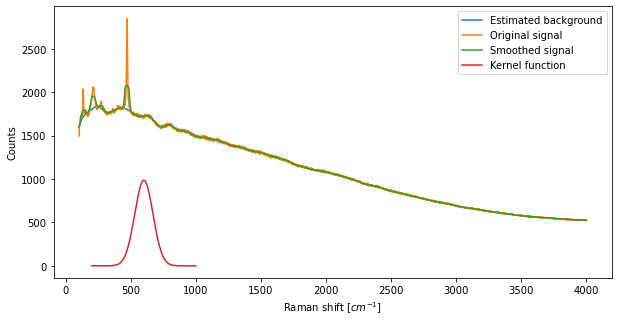

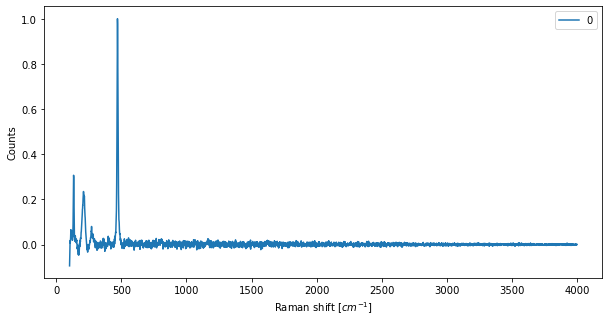

In [4]:
S=pr.type2spectra('txt10')
S=pr.bkg_subtraction(S,sigma=70,plot=True)
pr.plot(S)

  alias                         name     match
0  sch0  Quartz__X080015__Raman__780  0.980411
1  sch1  Quartz__X080016__Raman__532  0.968661
2  sch2  Quartz__X080015__Raman__532  0.966651
3  sch3  Quartz__X080016__Raman__780  0.963361
4  sch4  Quartz__R040031__Raman__514  0.951071
5  sch5  Quartz__R060604__Raman__780  0.950729
6  sch6  Quartz__R060604__Raman__532  0.948982
7  sch7  Quartz__R050125__Raman__780  0.947955
8  sch8  Quartz__R050125__Raman__532  0.944985
9  sch9  Quartz__R050125__Raman__514  0.940539


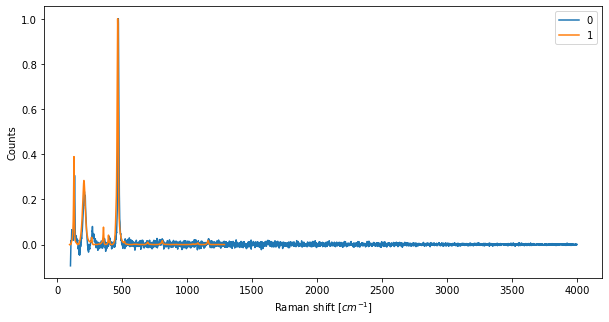

In [5]:
pr.search(S,shift=5);
pr.plot([S,'sch0'])

# 2D similarity - basic implementation

In [6]:
shift=10
per = 0.1

lib=pr.lib()
lib_names=list(lib.keys())

match = []
names = []
step = np.linspace(0,1,5)
step = step[1:-1]
for a in range(len(lib_names)):
    for b in range(len(lib_names)):
        if b>a:
            
            N = 2
            A=pr.lib(lib_names[a]).copy()
            A[1] /=  np.max(A[1])
            B=pr.lib(lib_names[b]).copy()
            B[1] /=  np.max(B[1])
            min = np.max([A[0,0],B[0,0]])
            max = np.min([A[0,-1],B[0,-1]])
            min_A = np.where(A[0]==min)[0][0]
            max_A = np.where(A[0]==max)[0][0]
            min_B = np.where(B[0]==min)[0][0]
            max_B = np.where(B[0]==max)[0][0]
            A = A[:,min_A:max_A]
            B = B[:,min_B:max_B]

            temp=[0,0]
            for i in step:
                X = np.array([A[0,:], i*A[1,:]+(1-i)*B[1,:]])
                t = pr.cos_sim_w_shift(S,X ,shift)
                if t>temp[1]:
                    temp[1] = t
                    temp[0] = str(i)+' '+lib_names[a]+', '+str(1-i)+' '+lib_names[b]
                
            
            x1 = pr.cos_sim_w_shift(S, pr.lib(lib_names[a]),shift) # da modificare il modo
            x2 = pr.cos_sim_w_shift(S, pr.lib(lib_names[b]),shift)
            if (temp[1]>np.max([x1,x2])*(1+per)): 
                names.append(temp[0])
                match.append(temp[1])
        
        if b==a:
            B = pr.lib(lib_names[a]).copy()
            names.append(lib_names[a])
            match.append(pr.cos_sim_w_shift(S,B,shift))
            

match = pd.DataFrame({'spectra':names, 'match':match})    
match.sort_values('match', ascending=False, inplace=True)
match.reset_index(inplace=True, drop=True)
print(match.head(10))

KeyboardInterrupt: 

# 2D search: looking for a smarter implementation

In [15]:
lib=pr.lib()
lib_names=list(lib.keys())
##########################################################
########### PUTTING THE LIBRARY IN AN NP.ARRAY ###########
##########################################################

# the nan values are padded with zeros!

m = len(lib_names)

# searching the minimum and the maximum wn of the library (to get the # of columns)
min = lib[lib_names[0]][0].min()
max = lib[lib_names[0]][0].max()

for el in lib_names[1:]:
    min_t = lib[el][0].min()
    max_t = lib[el][0].max()

    if min_t<min:
        min = min_t
    if max_t>max:
        max = max_t

wn = np.arange(min,max+1,1)
n = len(wn)

# rewriting the library in a np.array
LIB = np.zeros((m,n))

for i in range(len(lib_names)):
    min_t = lib[lib_names[i]][0].min()
    max_t = lib[lib_names[i]][0].max()
    
    LIB[i][int(min_t-min):n-int(max-max_t)]  = lib[lib_names[i]][1]

# rescaling the height to 1
LIB = (LIB.transpose()/LIB.max(axis=1)).transpose()

In [6]:
###########################################################################################################
############# GENERATING A LIBRARY OF THE SHIFTED SPECTRA, SPECIFYING FOR THE S WE ARE FACING #############
###########################################################################################################

##########################################
shift = 5
##########################################


# here we prepare common wn between S and the library

# ausiliar variables
LIB_temp = copy.deepcopy(LIB)
S_temp = copy.deepcopy(S)
S_temp[1] = S_temp[1]/S_temp[1].max()
wn_temp = copy.deepcopy(wn)

# changing dimensions of LIB_temp or S_temp
min_1 = np.min(S_temp[0])
min_2 = np.min(wn_temp)

if min_1<min_2:
    S_temp = S_temp[int(min_2-min_1):]
if min_2<min_1:
    wn_temp = wn_temp[int(min_1-min_2):]
    LIB_temp = LIB_temp[:,int(min_1-min_2):]

max_1 = np.max(S_temp[0])
max_2 = np.max(wn_temp)

if max_1>max_2:
    S_temp = S_temp[:,:int(max_2-max_1)]
if max_2>max_1:
    wn_temp = wn_temp[:int(max_1-max_2)]
    LIB_temp = LIB_temp[:,:int(max_1-max_2)]

# generate shifted spectra in LIB_temp
shift_vec = np.arange(-shift,shift+1)

LIB_temp_shifted = np.zeros((LIB_temp.shape[0]*len(shift_vec),LIB_temp.shape[1]))

for i in range(len(shift_vec)):
    if shift_vec[i]>0:
        LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],int(shift_vec[i]):] = LIB_temp[:,:-int(shift_vec[i])]
    if shift_vec[i]<0:
        LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],:int(shift_vec[i])] = LIB_temp[:,-int(shift_vec[i]):]
    if shift_vec[i]==0:
        LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],:] = LIB_temp[:,:]

LIB_temp = LIB_temp_shifted
del LIB_temp_shifted

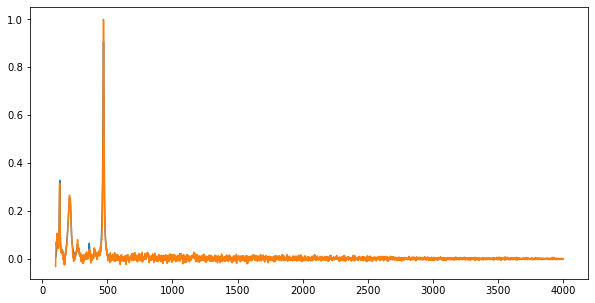

################################################################
# of used spectra =  10
                                  name  shift  regression coefficient
0        Bixbyite__R050395__Raman__785     -5                0.032892
1      Sperrylite__R070214__Raman__532     -5                0.021967
2     Scotlandite__R060764__Raman__785     -1                0.017162
3         Sulphur__R040135__Raman__514     -1                0.024666
4         Sulphur__R040135__Raman__514      0                0.011312
5       Covellite__R060129__Raman__532      1                0.057246
6       Rhodizite__R050099__Raman__532      1                0.030804
7  Paralaurionite__R050271__Raman__780      5                0.019854
8          Quartz__X080015__Raman__780      5                0.777464
9        Sodalite__R040141__Raman__514      5                0.015825


In [7]:
#############################################################################################
############# LINEAR REGRESSION FOR THE SEARCH OF USEFUL SPECTRA IN THE LIBRARY #############
#############################################################################################
 
#################################
th = 0.01 # trashold on the linear regression coefficients
#################################

# linear regression
reg = LinearRegression(fit_intercept=False, positive=True)
reg.fit(LIB_temp.transpose(),S_temp[1])

# plot the regression
plt.figure(figsize=(10,5))
plt.plot(wn_temp,np.dot(LIB_temp.transpose(),reg.coef_))
plt.plot(S_temp[0],S_temp[1])
plt.show()

# delete (big) LIB_temp variable
del LIB_temp

# number of used spectrums used, selection of rely used spectra
count=0
lib_used = []
for i in range(len(reg.coef_)):
    if reg.coef_[i]>th:
        count+=1
        lib_used.append(i)

print('################################################################')
print('# of used spectra = ',count)

# selected spectra sumup
sumup = []
for i in range(len(lib_used)):
    sumup.append([lib_names[lib_used[i] - m*(lib_used[i]//m)] , shift_vec[lib_used[i]//m], reg.coef_[lib_used[i]]])

sumup = pd.DataFrame(sumup, columns=['name','shift','regression coefficient'])
print(sumup)

In [8]:
#########################################################################################
############# GENERATION OF THE REQUIRED SPECTRA IN THE RIGHT CONFIGURATION #############
#########################################################################################

# generation of the required pure spectra (also shifted)

pure = [0] * len(sumup.index)
for i in sumup.index:
    pure[i] = copy.deepcopy(lib[sumup.name[i]])
    pure[i][0] = pure[i][0]+sumup['shift'][i]
    pure[i][1] = pure[i][1]/pure[i][1].max()


# per semplicità restringiamo subito tutto allo stesse common wn

    # calcolo min e max della combinazione

min = S[0].min()
max = S[0].max()

for el in sumup.index:
    min_pure = pure[el][0].min()
    max_pure = pure[el][0].max()

    if min_pure>min:
        min = min_pure
    if max_pure<max:
        max = max_pure
    # e ora restringiamo

        # prima S in S_temp
S_temp = copy.deepcopy(S)
S_temp[1] = S_temp[1]/S_temp[1].max()

if S_temp[0].min()<min:
    S_temp = S_temp[:,int(min-S_temp[0].min()):]
if S_temp[0].max()>max:
    S_temp = S_temp[:,:-int(S_temp[0].max()-max)]

        # poi i pure spectra
for el in sumup.index:
    if pure[el][0].min()<min:
        pure[el] = pure[el][:,int(min-pure[el][0].min()):]
    if pure[el][0].max()>max:
        pure[el] = pure[el][:,:-int(pure[el][0].max()-max)]

In [34]:
#############################################################
############# FINAL FIT USING COSINE SIMILARITY #############
#############################################################

N = 4

# genero le N combinazioni tra i pure spectra selezionati
comb = list(combinations(list(sumup.index),N))
# eliminare combinazioni dello stesso spettro shiftato??????


print('trying N =', N,'; resulting in', len(comb), 'combinations')

# and finaly let's compute the similarity for each combination
results = [0]*len(comb)

for c in enumerate(comb):
    
    if N>1:
        # minimization of the problem
        def fun(intensity):
            intensity = np.concatenate(([1],intensity))
            tot = np.zeros(len(S_temp[1]))

            for i in range(N):
                tot += pure[c[1][i]][1] * intensity[i]
            return -np.dot(S_temp[1],tot) / np.sqrt(np.dot(S_temp[1],S_temp[1])*np.dot(tot,tot))

        X = scipy.optimize.minimize(fun, [1]*(N-1), method='Nelder-Mead', bounds=[(0,100)]*(N-1))
        if X.success==False:
            print('error in the optimization!!!')

        # store results
        # combination, intensity, similarity
        results[c[0]] = [c[1], X.fun ]
    
    if N==1:
        tot = pure[c[1][0]][1]
        results[c[0]] = [c[1], -np.dot(S_temp[1],tot) / np.sqrt(np.dot(S_temp[1],S_temp[1])*np.dot(tot,tot)) ]

for i in range(len(results)):
    temp = [0]*N
    for j in range(N):
        temp[j]= sumup.name[results[i][0][j]]

    results[i][0] = temp
results = pd.DataFrame(results, columns=['combination','similarity'])


results['similarity'] = -results['similarity']
results.sort_values(by=['similarity'], inplace=True, ascending=False)

display(results.head())

trying N = 4 ; resulting in 210 combinations


,combination,similarity
100,"[Sperrylite__R070214__Raman__532, Scotlandite_...",0.989104
138,"[Sperrylite__R070214__Raman__532, Rhodizite__R...",0.988711
115,"[Sperrylite__R070214__Raman__532, Sulphur__R04...",0.988608
136,"[Sperrylite__R070214__Raman__532, Rhodizite__R...",0.988608
97,"[Sperrylite__R070214__Raman__532, Scotlandite_...",0.988308


## Let's make all this more compact

### Inizialization of the library matrix

In [7]:
lib=pr.lib()
lib_names=list(lib.keys())

##########################################################
########### PUTTING THE LIBRARY IN AN NP.ARRAY ###########
##########################################################

# the nan values are padded with zeros!

m = len(lib_names)

# searching the minimum and the maximum wn of the library (to get the # of columns)
min = lib[lib_names[0]][0].min()
max = lib[lib_names[0]][0].max()

for el in lib_names[1:]:
    min_t = lib[el][0].min()
    max_t = lib[el][0].max()

    if min_t<min:
        min = min_t
    if max_t>max:
        max = max_t

wn = np.arange(min,max+1,1)
n = len(wn)

# rewriting the library in a np.array
LIB = np.zeros((m,n))

for i in range(len(lib_names)):
    min_t = lib[lib_names[i]][0].min()
    max_t = lib[lib_names[i]][0].max()
    
    LIB[i][int(min_t-min):n-int(max-max_t)]  = lib[lib_names[i]][1]

# rescaling the height to 1
LIB = (LIB.transpose()/LIB.max(axis=1)).transpose()

In [8]:
#################################
shift = 3
th = 0.01 # trashold on the linear regression coefficients
improvement_th = 0.1
#################################

def NDsearch(S, shift, th=0.01, improvement_th = 0.1, verbose=False):

    ###########################################################################################################
    ############# GENERATING A LIBRARY OF THE SHIFTED SPECTRA, SPECIFYING FOR THE S WE ARE FACING #############
    ###########################################################################################################

    # here we prepare common wn between S and the library

    # ausiliar variables
    LIB_temp = copy.deepcopy(LIB)
    S_temp = copy.deepcopy(S)
    S_temp[1] = S_temp[1]/S_temp[1].max()
    wn_temp = copy.deepcopy(wn)

    # changing dimensions of LIB_temp or S_temp
    min_1 = np.min(S_temp[0])
    min_2 = np.min(wn_temp)

    if min_1<min_2:
        S_temp = S_temp[int(min_2-min_1):]
    if min_2<min_1:
        wn_temp = wn_temp[int(min_1-min_2):]
        LIB_temp = LIB_temp[:,int(min_1-min_2):]

    max_1 = np.max(S_temp[0])
    max_2 = np.max(wn_temp)

    if max_1>max_2:
        S_temp = S_temp[:,:int(max_2-max_1)]
    if max_2>max_1:
        wn_temp = wn_temp[:int(max_1-max_2)]
        LIB_temp = LIB_temp[:,:int(max_1-max_2)]

    # generate shifted spectra in LIB_temp
    shift_vec = np.arange(-shift,shift+1)

    LIB_temp_shifted = np.zeros((LIB_temp.shape[0]*len(shift_vec),LIB_temp.shape[1]))

    for i in range(len(shift_vec)):
        if shift_vec[i]>0:
            LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],int(shift_vec[i]):] = LIB_temp[:,:-int(shift_vec[i])]
        if shift_vec[i]<0:
            LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],:int(shift_vec[i])] = LIB_temp[:,-int(shift_vec[i]):]
        if shift_vec[i]==0:
            LIB_temp_shifted[i*LIB_temp.shape[0]:(i+1)*LIB_temp.shape[0],:] = LIB_temp[:,:]

    LIB_temp = LIB_temp_shifted
    del LIB_temp_shifted

    #############################################################################################
    ############# LINEAR REGRESSION FOR THE SEARCH OF USEFUL SPECTRA IN THE LIBRARY #############
    #############################################################################################
    
    # linear regression
    reg = LinearRegression(fit_intercept=False, positive=True)
    reg.fit(LIB_temp.transpose(),S_temp[1])


    if verbose:
        # plot the regression
        plt.figure(figsize=(10,5))
        plt.plot(wn_temp,np.dot(LIB_temp.transpose(),reg.coef_))
        plt.plot(S_temp[0],S_temp[1])
        plt.show()

    # delete (big) LIB_temp variable
    del LIB_temp

    # number of used spectrums used, selection of rely used spectra
    count=0
    lib_used = []
    for i in range(len(reg.coef_)):
        if reg.coef_[i]>th:
            count+=1
            lib_used.append(i)

    if verbose:
        print('################################################################')
        print('# of used spectra = ',count)

    # selected spectra sumup
    sumup = []
    for i in range(len(lib_used)):
        sumup.append([lib_names[lib_used[i] - m*(lib_used[i]//m)] , shift_vec[lib_used[i]//m], reg.coef_[lib_used[i]]])

    sumup = pd.DataFrame(sumup, columns=['name','shift','regression coefficient'])

    if verbose:    
        print(sumup)


    #########################################################################################
    ############# GENERATION OF THE REQUIRED SPECTRA IN THE RIGHT CONFIGURATION #############
    #########################################################################################

    # generation of the required pure spectra (also shifted)
    pure = [0] * len(sumup.index)
    for i in sumup.index:
        pure[i] = copy.deepcopy(lib[sumup.name[i]])
        pure[i][0] = pure[i][0]+sumup['shift'][i]
        pure[i][1] = pure[i][1]/pure[i][1].max()


    # per semplicità restringiamo subito tutto allo stesse common wn

        # calcolo min e max della combinazione

    min = S[0].min()
    max = S[0].max()

    for el in sumup.index:
        min_pure = pure[el][0].min()
        max_pure = pure[el][0].max()

        if min_pure>min:
            min = min_pure
        if max_pure<max:
            max = max_pure
        # e ora restringiamo

            # prima S in S_temp
    S_temp = copy.deepcopy(S)
    S_temp[1] = S_temp[1]/S_temp[1].max()

    if S_temp[0].min()<min:
        S_temp = S_temp[:,int(min-S_temp[0].min()):]
    if S_temp[0].max()>max:
        S_temp = S_temp[:,:-int(S_temp[0].max()-max)]

            # poi i pure spectra
    for el in sumup.index:
        if pure[el][0].min()<min:
            pure[el] = pure[el][:,int(min-pure[el][0].min()):]
        if pure[el][0].max()>max:
            pure[el] = pure[el][:,:-int(pure[el][0].max()-max)]

    #############################################################
    ############# FINAL FIT USING COSINE SIMILARITY #############
    #############################################################

    N = 0
    improvement = 1
    out = []

    while improvement>improvement_th:

        N += 1

        if N == 1:
            print('trying N =', N)
            match = pr.search(S, shift, verbose=False)
            match.drop(columns=['alias'], inplace=True)

        if N>1:

            # genero le N combinazioni tra i pure spectra selezionati
            comb = list(combinations(list(sumup.index),N))
            # eliminare combinazioni dello stesso spettro shiftato??????


            print('trying N =', N,'; resulting in', len(comb), 'combinations')

            # and finaly let's compute the similarity for each combination
            match = [0]*len(comb)

            for c in enumerate(comb):
                
                # minimization of the problem
                def fun(intensity):
                    intensity = np.concatenate(([1],intensity))
                    tot = np.zeros(len(S_temp[1]))

                    for i in range(N):
                        tot += pure[c[1][i]][1] * intensity[i]
                    return -np.dot(S_temp[1],tot) / np.sqrt(np.dot(S_temp[1],S_temp[1])*np.dot(tot,tot))

                X = scipy.optimize.minimize(fun, [1]*(N-1), method='Nelder-Mead', bounds=[(0,100)]*(N-1))
                if X.success==False:
                    print('error in the optimization!!!')

                # store results
                # combination, intensity, similarity
                match[c[0]] = [c[1], X.fun ]
                

            for i in range(len(match)):
                temp = [0]*N
                for j in range(N):
                    temp[j]= sumup.name[match[i][0][j]]

                match[i][0] = temp
            match = pd.DataFrame(match, columns=['name','match'])

            match['match'] = -match['match']
            match.sort_values(by=['match'], inplace=True, ascending=False)
            match.reset_index(inplace=True, drop=True)


        out.append(match)
        if N>1:
            improvement = (out[N-1].match.max()-out[N-2].match.max())/out[N-2].match.max()
        

    print('########################################################')
    print('best at N =', N-1)
    print(out[N-2].head(10))
    print('########################################################')
    return out[N-2]

### Some test

sum(Y-XW) =  -5722993.123502118
message =  Optimization terminated successfully.
# of iter =  1296


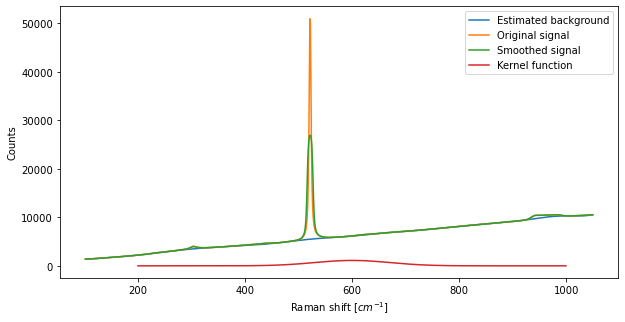

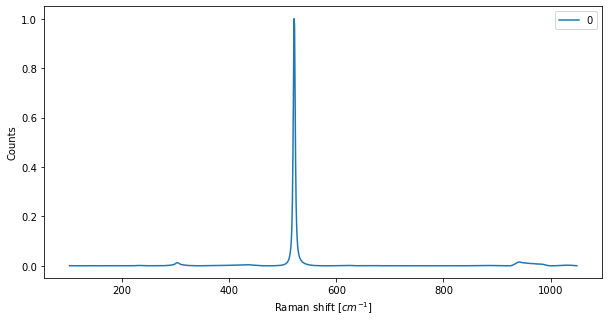

trying N = 1
trying N = 2 ; resulting in 1 combinations
########################################################
best at N = 1
                               name     match
0      Silicon__R040145__Raman__514  0.983211
1      Silicon__R040145__Raman__532  0.898654
2     Mesolite__R050013__Raman__785  0.809740
3  Edingtonite__R040110__Raman__514  0.805685
4  Edingtonite__R040003__Raman__532  0.803520
5  Edingtonite__R040003__Raman__785  0.796559
6      Coesite__R070565__Raman__780  0.792928
7     Sanidine__R060313__Raman__785  0.792330
8  Epididymite__R060773__Raman__785  0.780822
9  Edingtonite__R040110__Raman__785  0.779823
########################################################


In [9]:
S=pr.type2spectra('txt11')
S[1]=S[1]+10*S[0]
S=pr.bkg_subtraction(S,sigma=70,plot=True, L_n=11)
pr.plot(S)


NDsearch(S,10);

sum(Y-XW) =  -22245035.40188161
message =  Optimization terminated successfully.
# of iter =  2942


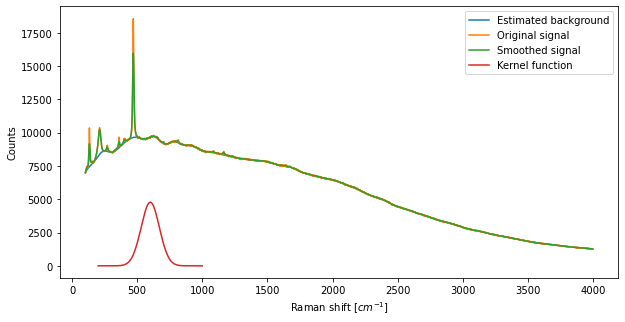

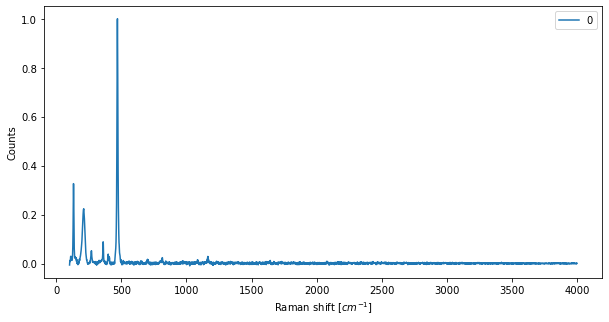

In [11]:
S=pr.type2spectra('txt3')
S[1]=S[1]
S=pr.bkg_subtraction(S,sigma=70,plot=True, L_n=11)
pr.plot(S)

In [12]:
NDsearch(S,10);